# Signal vs. background classification with NEW full MC

In this notebook we read in the prepared data, construct and train the DNN, and then evaluate its performance.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy  as np
import random as rd
import tables as tb
import h5py
import tensorflow as tf

from matplotlib.patches         import Ellipse
from __future__  import print_function
from scipy.stats import threshold

# Keras imports
import keras.backend.tensorflow_backend as K
from keras.models               import Model, load_model
from keras.layers               import Input, Dense, MaxPooling3D, AveragePooling3D, Convolution3D, Activation, Dropout, merge
from keras.layers.normalization import BatchNormalization
from keras.optimizers           import SGD, Adam, Nadam         
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core          import Flatten
from keras                      import callbacks
from keras.regularizers         import l2, l1
from keras.initializers         import RandomNormal

Using TensorFlow backend.


# Variable definitions
Here we define key variables to be used throughout the notebook.  Note that we will read the data from a directory `data_location/run_name`, and it is stored in multiple files:
- The training data will consist of the events stored in files from `train_fstart` to `train_fend`
- The test data will consist of the events stored in files from `test_fstart` to `test_fend`

In [2]:
# data dimensions
xdim = 20
ydim = 20
zdim = 60

# data location and training/test file numbers
data_location = "/home/jrenner/data/classification"
run_name = "1M_v0_08_07"
train_fstart = 0
train_fend = 5
test_fstart = 5
test_fend = 6

## Function definitions

### Data input functions

In [12]:
# define the function to read the data from multiple files
def read_data(loc, rname, f_start, f_end, fval):
    """Reads all events from the files with the specified file numbers."""
    
    # read in the signal events.
    print("Reading signal events...")
    for fn in range(f_start,f_end):
        s_dat = tb.open_file("{0}/{1}/hdf5_maps_NEW_training_MC_si_{2}.h5".format(loc,rname,fn), 'r')
        if(fn == f_start):
            s_array = np.array(s_dat.root.maps)
            s_energies = np.array(s_dat.root.energies)
            print("-- Reading file {0},".format(fn), end=' ')
        else:
            print("{0},".format(fn), end=' ')
            s_array = np.concatenate([s_array,np.array(s_dat.root.maps)])
            s_energies = np.concatenate([s_energies,np.array(s_dat.root.energies)])
    print("done.")

    # read in the background events.
    print("\nReading background events...")
    for fn in range(f_start,f_end):
        b_dat = tb.open_file("{0}/{1}/hdf5_maps_NEW_training_MC_bg_{2}.h5".format(loc,rname,fn), 'r')
        if(fn == f_start):
            print("-- Reading file {0},".format(fn), end=' ')
            b_array = np.array(b_dat.root.maps)
            b_energies = np.array(b_dat.root.energies)
        else:
            print("{0},".format(fn), end=' ')
            b_array = np.concatenate([b_array,np.array(b_dat.root.maps)])
            b_energies = np.concatenate([b_energies,np.array(b_dat.root.energies)])
    print("done.")
    print("\nRead {0} signal events and {1} background events.".format(len(s_array),len(b_array)))
        
    # concatenate the datasets, splitting into training and validation sets
    print("Concatenating datasets...")
    nval = int(fval * (len(s_array) + len(b_array)))
    
    if(nval == 0):
        x_ = np.concatenate([s_array, b_array])
        y_ = np.concatenate([np.ones([len(s_array), 1]), np.zeros([len(b_array), 1])])

        # reshape for training with TensorFlow        
        print("Reshaping projection...")
        x_ = np.reshape(x_, (len(x_), xdim, ydim, zdim, 1))
        print("Finished reading data: {0} training/test events".format(len(x_)))
        return x_,y_
    else:
        x_ = np.concatenate([s_array[0:-nval], b_array[0:-nval]])
        y_ = np.concatenate([np.ones([len(s_array[0:-nval]), 1]), np.zeros([len(b_array[0:-nval]), 1])])
        xval_ = np.concatenate([s_array[-nval:], b_array[-nval:]])
        yval_ = np.concatenate([np.ones([len(s_array[-nval:]), 1]), np.zeros([len(b_array[-nval:]), 1])])

        # reshape for training with TensorFlow
        print("Reshaping projection...")
        x_ = np.reshape(x_, (len(x_), xdim, ydim, zdim, 1))
        xval_ = np.reshape(xval_, (len(xval_), xdim, ydim, zdim, 1))
        print("Finished reading data: {0} training/test and {1} validation events".format(len(x_),len(xval_)))
        return x_,y_,xval_,yval_

### Neural network models
These functions should define and return a Keras model object.

In [4]:
##################################
# Define more neural networks here

def model_3D(inputs):
    
    cinputs = Convolution3D(256, 5, 5, 5, border_mode='same', subsample=(4, 4, 4), activation='relu',init='lecun_uniform', W_regularizer=l2(0.000001))(inputs)
    cinputs = MaxPooling3D(pool_size=(3, 3, 3), strides=(2, 2, 2), border_mode='same', dim_ordering='default')(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, mode=0, axis=4, momentum=0.99, weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
    cinputs = Convolution3D(64, 1, 1, 1, border_mode='same', subsample=(1, 1, 1), activation='relu',init='lecun_uniform', W_regularizer=l2(0.000001))(cinputs)
    cinputs = Convolution3D(128, 2, 2, 3, border_mode='same', subsample=(2, 2, 3), activation='relu',init='lecun_uniform', W_regularizer=l2(0.000001))(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, mode=0, axis=4, momentum=0.99, weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
    cinputs = Convolution3D(128, 1, 1, 1, border_mode='same', subsample=(1, 1, 1), activation='relu',init='lecun_uniform', W_regularizer=l2(0.000001))(cinputs)
    cinputs = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), border_mode='same', dim_ordering='default')(cinputs)
    f1 = Flatten()(cinputs)
    f1 = Dense(output_dim=128, activation='relu', init='lecun_uniform', W_regularizer=l2(0.000001))(f1)
    f1 = Dropout(.3)(f1)

    inc_output = Dense(output_dim=1, activation='sigmoid',init='normal', W_regularizer=l2(0.000001))(f1)
    model = Model(inputs, inc_output)
    
    model.compile(loss='binary_crossentropy',
                optimizer=Nadam(lr=0.00001, beta_1=0.9, beta_2=0.999,
                                epsilon=1e-08, schedule_decay=0.01), metrics=['accuracy'])
    
    # ----------
    return model

In [5]:
#testmodel
def model_test(inpus):
    f1 = Flatten()(inputs)
    f1 = Dense(units=128, kernel_initializer="normal", activation="relu", kernel_regularizer=l2(0.00001), activity_regularizer=l1(0.00001))(f1)
    f1 = Dropout(.7)(f1)
    inc_output = Dense(units=1, kernel_initializer="normal", activation="sigmoid")(f1)
    model = Model(inputs, inc_output)

    model.compile(loss='binary_crossentropy',
                  optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004), metrics=['accuracy'])  
    return model

In [6]:
# define a fully-connected neural network with 64 hidden neurons and 1 readout neuron
def model_FC(inputs):
    
    f1 = Flatten()(inputs)
    f1 = Dense(units=64, kernel_initializer="normal", activation="sigmoid")(f1)
    f1 = Dense(units=64, kernel_initializer="normal", activation="sigmoid")(f1)
    f1 = Dense(units=64, kernel_initializer="normal", activation="sigmoid")(f1)
    f1 = Dropout(.3)(f1)
    inc_output = Dense(units=1, kernel_initializer="normal", activation="sigmoid")(f1)
    model = Model(inputs, inc_output)

    model.compile(loss='binary_crossentropy',
                  optimizer=Nadam(lr=0.00001, beta_1=0.9, beta_2=0.999,
                                  epsilon=1e-08, schedule_decay=0.01),
                                  metrics=['accuracy'])  
    return model

In [7]:
# plot a 20x20 SiPM map
# -- carried over from NEW_kr_diff_mc_train.ipynb
def NEW_SiPM_map_plot(xarr, normalize=True):
    """
    Plots a SiPM map in the NEW Geometry
    xarr is a NEW sipm map, yarr the pair of coordinates the map corresponds to
    """
    if normalize:
        probs = (xarr - np.min(xarr))
        probs /= np.max(probs)
    else: 
        probs = xarr

    # set up the figure
    fig = plt.figure();
    ax1 = fig.add_subplot(111);
    fig.set_figheight(5.0)
    fig.set_figwidth(5.0)
    ax1.axis([-100, 100, -100, 100]);

    for i in range(20):
        for j in range(20):
            r = Ellipse(xy=(i * 10 - 95, j * 10 - 95), width=2., height=2.);
            r.set_facecolor('0');
            r.set_alpha(probs[i, j]);
            ax1.add_artist(r);
        
    plt.xlabel("x (mm)");
    plt.ylabel("y (mm)");

## Load in the data

In [13]:
# read in the training data
x_train, y_train, x_val, y_val = read_data(data_location, run_name, train_fstart, train_fend, 0.1)

Reading signal events...
-- Reading file 0, 1, 2, 3, 4, done.

Reading background events...
-- Reading file 0, 1, 2, 3, 4, done.

Read 9521 signal events and 8940 background events.
Concatenating datasets...
Reshaping projection...
Finished reading data: 14769 training/test and 3692 validation events


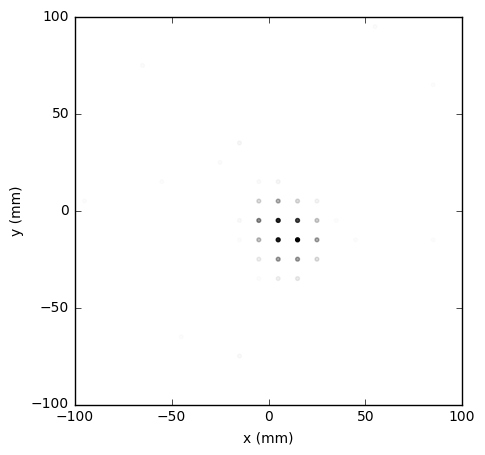

In [14]:
# plot one slice of one event
NEW_SiPM_map_plot(x_train[0,:,:,18,0])

## Define and train the DNN

In [15]:
# set load_model to true and specify the file to load in a previously defined/trained model
load_weights = False
mfile = 'models/conv3d_classifier.h5'

if(load_weights):
    model = load_model(mfile)
else:
    
    # otherwise define the model
    inputs = Input(shape=(xdim, ydim, zdim, 1))
    model = model_test(inputs)
    
    # define callbacks (actions to be taken after each epoch of training)
    file_lbl = "{epoch:02d}-{loss:.4f}"
    filepath="weights-{0}.h5".format(file_lbl)
    checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    lcallbacks = [checkpoint]            
    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 20, 60, 1)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3072128   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 3,072,257.0
Trainable params: 3,072,257.0
Non-trainable params: 0.0
_________________________________________________________________


In [ ]:
# train the model
hist = model.fit(x_train, y_train, shuffle=True, epochs=20, batch_size=200, verbose=1, validation_data=(x_val,y_val), callbacks=lcallbacks)

## Test the trained model

In [16]:
# read in the test data
x_test, y_test = read_data(data_location, run_name, test_fstart + 4 , test_fend  + 10, 0.0)

Reading signal events...
-- Reading file 9, 10, 11, 12, 13, 14, 15, done.

Reading background events...
-- Reading file 9, 10, 11, 12, 13, 14, 15, done.

Read 13284 signal events and 12470 background events.
Concatenating datasets...
Reshaping projection...
Finished reading data: 25754 training/test events


In [ ]:
# compute the predictions
loss_and_metrics = model.evaluate(x_test, y_test);
y_pred = model.predict(x_test, batch_size=100, verbose=0)
print(loss_and_metrics)